# Step 0: Explore the dataset

In [1]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 14.1 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1116 entries, 0 to 1115
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   fecha_resultado     1116 non-null   object
 1   departamento        1116 non-null   object
 2   provincia           1116 non-null   object
 3   distrito            1116 non-null   object
 4   num_death_cases     1116 non-null   int64 
 5   num_positive_cases  1116 non-null   int64 
dtypes: int64(2), object(4)
memory usage: 52.4+ KB


<Axes: >

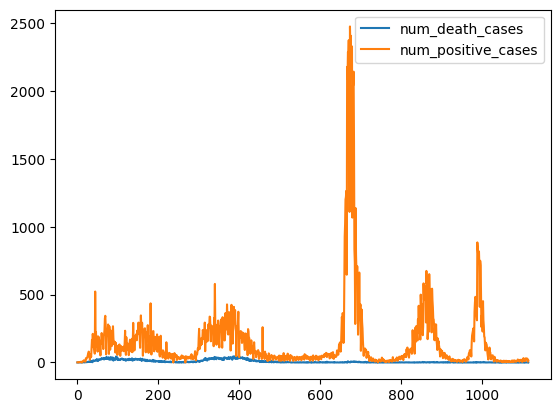

In [3]:
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/DSA5900/LIMA_DPT_PVN_DISTRICT.csv')
df.info()

df.plot()

In [4]:
df['fecha_resultado'] = pd.to_datetime(df['fecha_resultado'], format='%Y/%m/%d')

In [5]:
df['Year'] = df['fecha_resultado'].dt.year
df['Month'] = df['fecha_resultado'].dt.month
df['Day'] = df['fecha_resultado'].dt.day
df['ds'] = pd.to_datetime(df[['Year', 'Month', 'Day']])

In [6]:
df.drop(['fecha_resultado', 'departamento', 'provincia', 'distrito','num_death_cases', 'Year', 'Month', 'Day', ], axis=1, inplace= True)
df.columns = ['y', 'ds']

In [7]:
df['ds'] = pd.to_datetime(df['ds'])
df.set_index('ds', inplace=True)

In [8]:
df['y'] = df['y'].cumsum()


<Axes: xlabel='ds'>

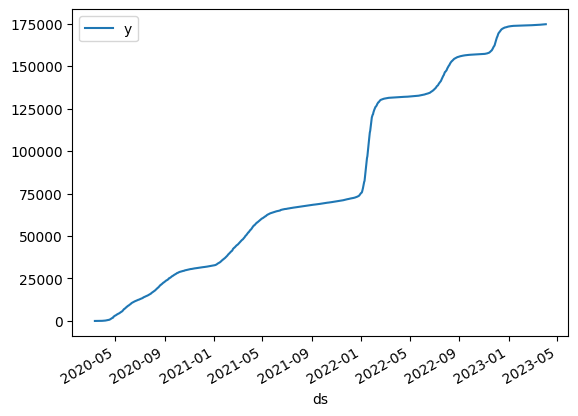

In [9]:
import numpy as np
#df = np.log(df['y']) # don't forget to transform the data back when making real predictions

df.plot()

In [10]:
df

,y
ds,
2020-03-12,1
2020-03-14,2
2020-03-15,5
2020-03-16,6
2020-03-17,7
...,...
2023-03-30,174637
2023-03-31,174659
2023-04-01,174686


In [49]:
# msk = (df.index < len(df)-30)
# df_train = df[msk].copy()
# df_test = df[~msk].copy()

# Splitting the data into training and testing sets
train_size = int(len(df['y']) * 0.80)
df_train = df['y'][:train_size]
df_test = df['y'][train_size:]

# Step 1: Check for stationarity of time series

## Method #1: time series plot

## Method #2: ACF plot and PACF plot

/usr/local/lib/python3.9/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


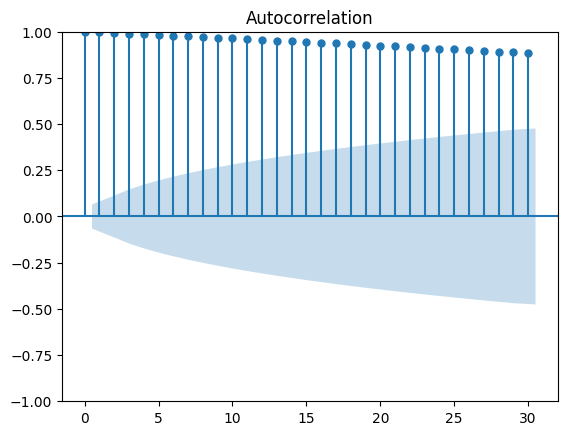

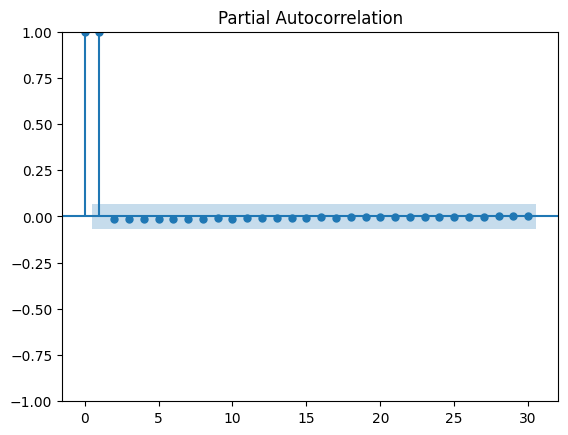

In [50]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

acf_original = plot_acf(df_train)

pacf_original = plot_pacf(df_train)

## Method #3: ADF test

In [51]:
from statsmodels.tsa.stattools import adfuller
adf_test = adfuller(df_train)
print(f'p-value: {adf_test[1]}')

p-value: 0.9590879456329489


## Transform to stationary: differencing

<Axes: xlabel='ds'>

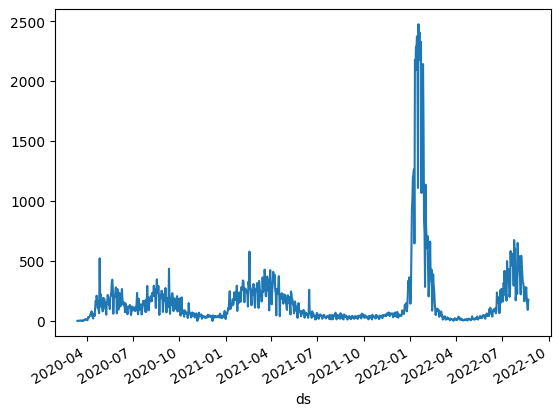

In [52]:
df_train_diff = df_train.diff().dropna()
df_train_diff.plot()

/usr/local/lib/python3.9/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


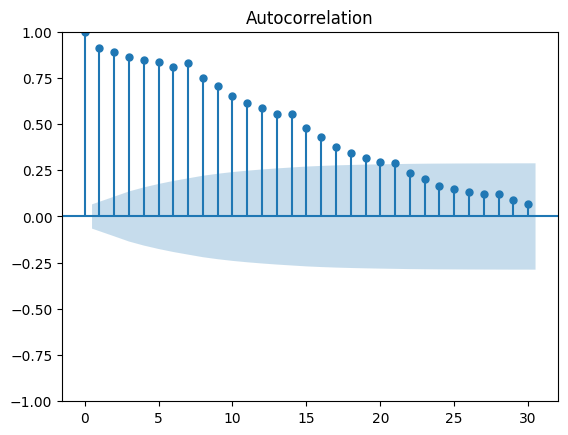

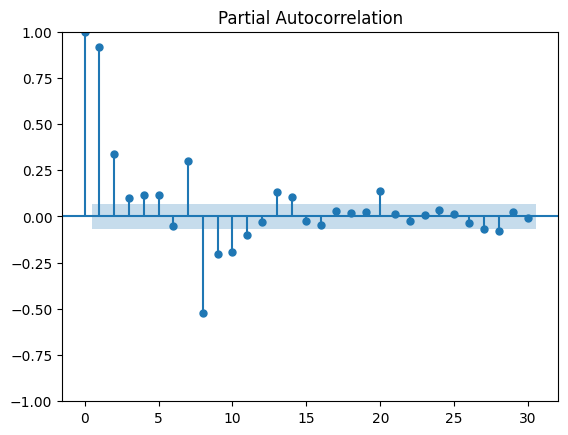

In [53]:
acf_diff = plot_acf(df_train_diff)

pacf_diff = plot_pacf(df_train_diff)

In [54]:
adf_test = adfuller(df_train_diff)
print(f'p-value: {adf_test[1]}')

p-value: 0.0014535988472135642


# Step 2: Determine ARIMA models parameters p, q

# Step 3: Fit the ARIMA model

In [55]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(df_train, order=(7,1,4))
model_fit = model.fit()
print(model_fit.summary())

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  892
Model:                 ARIMA(7, 1, 4)   Log Likelihood               -5385.811
Date:                Thu, 27 Apr 2023   AIC                          10795.622
Time:                        07:57:18   BIC                          10853.130
Sample:                             0   HQIC                         10817.601
                                - 892                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2408      0.036      6.700      0.000       0.170       0.311
ar.L2          0.2179      0.033      6.562      0.000       0.153       0.283
ar.L3         -0.3262      0.038     -8.598      0.0

/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


# Step 4: Make time series predictions

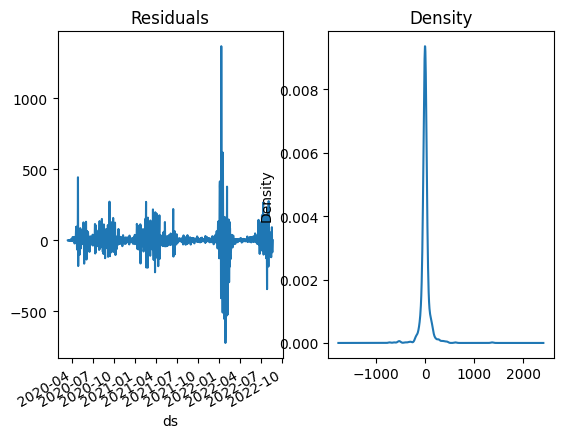

In [56]:
import matplotlib.pyplot as plt
residuals = model_fit.resid[1:]
fig, ax = plt.subplots(1,2)
residuals.plot(title='Residuals', ax=ax[0])
residuals.plot(title='Density', kind='kde', ax=ax[1])
plt.show()

/usr/local/lib/python3.9/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


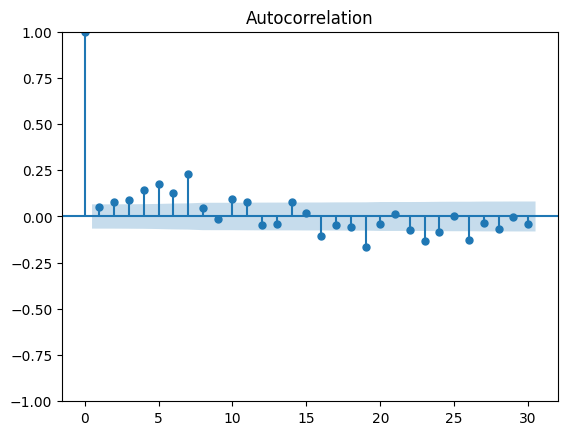

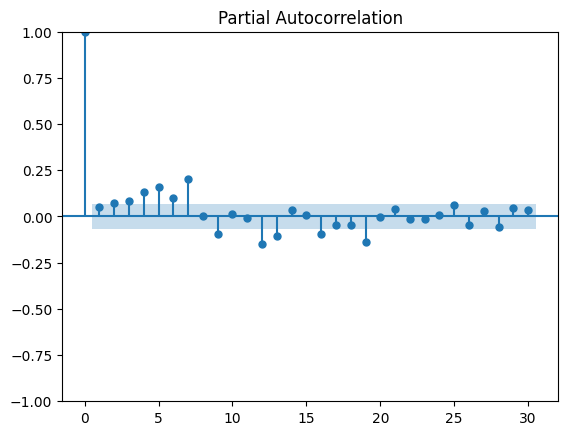

In [57]:
acf_res = plot_acf(residuals)

pacf_res = plot_pacf(residuals)

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


<Axes: xlabel='ds'>

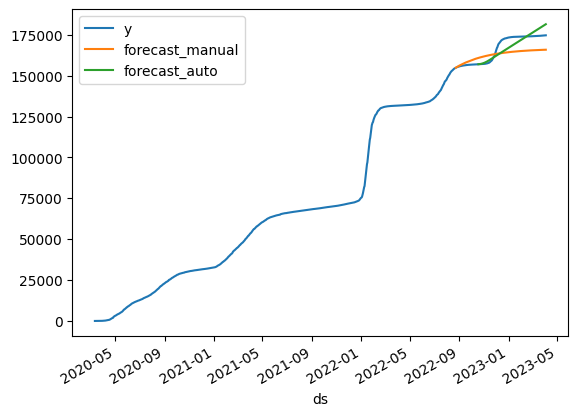

In [58]:
forecast_test = model_fit.forecast(len(df_test))

df['forecast_manual'] = [None]*len(df_train) + list(forecast_test)

df.plot()

# Optional: Auto-fit the ARIMA model

In [59]:
import pmdarima as pm
auto_arima = pm.auto_arima(df_train, stepwise=False, seasonal=False)
auto_arima

ARIMA(order=(3, 2, 2), scoring_args={}, suppress_warnings=True)

In [60]:
auto_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  892
Model:               SARIMAX(3, 2, 2)   Log Likelihood               -5466.774
Date:                Thu, 27 Apr 2023   AIC                          10947.547
Time:                        07:57:46   BIC                          10981.086
Sample:                             0   HQIC                         10960.366
                                - 892                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0737      2.211     -0.033      0.973      -4.407       4.259
ar.L1          0.8663      0.017     52.203      0.000       0.834       0.899
ar.L2         -0.4042      0.018    -22.767      0.000      -0.439      -0.369
ar.L3         -0.3646      0.016    -22.920      0.000      -0.396      -0.333
ma.L1         -1.3891      0.011   -123.794      0.000      -1.411      -1.367
ma.L2          0.8934      0.010     93.442      0.000       0.875       0.912
sigma2      1.266e+04    164.500     76.953      0.000    1.23e+04     1.3e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.32   Jarque-Bera (JB):             58400.62
Prob(Q):                              0.57   Prob(JB):                         0.00
Heteroskedasticity (H):               8.39   Skew:                            -1.47
Prob(H) (two-sided):                  0.00   Kurtosis:                        42.58
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# Step 5: Evaluate model predictions

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


<Axes: title={'center': 'Lima District Deaths Forecast'}, xlabel='Date', ylabel='Count'>

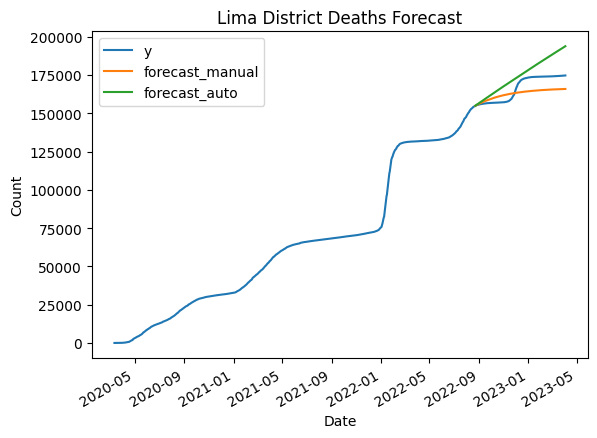

In [61]:
forecast_test_auto = auto_arima.predict(n_periods=len(df_test))
df['forecast_auto'] = [None]*len(df_train) + list(forecast_test_auto)

df.plot(title='Lima District Deaths Forecast', ylabel='Count', xlabel= 'Date')

In [62]:
df

,y,forecast_manual,forecast_auto
ds,,,
2020-03-12,1,NaN,NaN
2020-03-14,2,NaN,NaN
2020-03-15,5,NaN,NaN
2020-03-16,6,NaN,NaN
2020-03-17,7,NaN,NaN
...,...,...,...
2023-03-30,174637,165856.637877,193148.444999
2023-03-31,174659,165865.564608,193313.726201
2023-04-01,174686,165874.375930,193478.926072


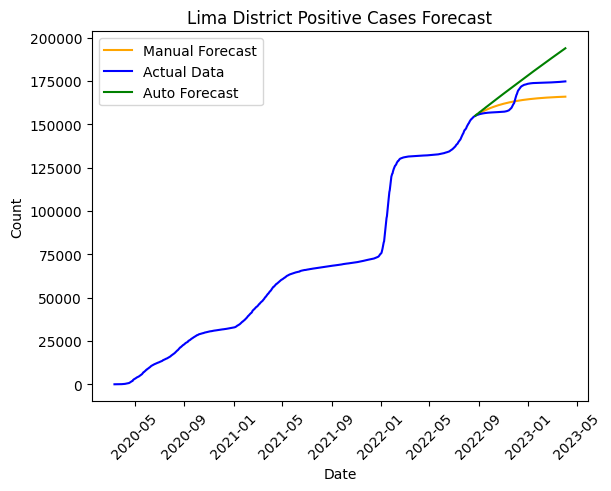

In [70]:
plt.figure()
plt.plot(df[['forecast_manual']], c='orange', label='Manual Forecast')
plt.plot(df[['y']], c='blue', label='Actual Data')
plt.plot(df[['forecast_auto']], c='green', label='Auto Forecast')
plt.xlabel('Date')
plt.ylabel('Count')
plt.xticks(fontsize=10)
plt.xticks(rotation=45)
plt.yticks(fontsize=10)
plt.title("Lima District Positive Cases Forecast")
plt.legend()
plt.show()

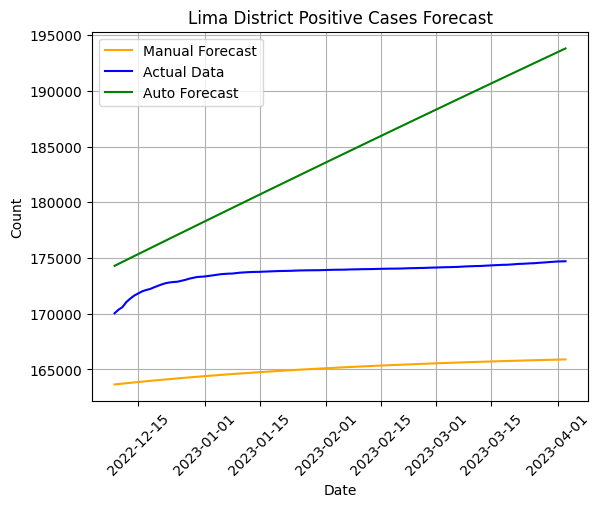

In [69]:
plt.figure()
plt.plot(df[['forecast_manual']][-116:], c='orange', label='Manual Forecast')
plt.plot(df[['y']][-116:], c='blue', label='Actual Data')
plt.plot(df[['forecast_auto']][-116:], c='green', label='Auto Forecast')
plt.xlabel('Date')
plt.ylabel('Count')
plt.xticks(fontsize=10)
plt.xticks(rotation=45)
plt.yticks(fontsize=10)
plt.title("Lima District Positive Cases Forecast")
plt.legend()
plt.grid()
plt.show()

In [67]:
# Arima District Positive Cases Error (Manual Forecast)
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

mae = mean_absolute_error(df_test, forecast_test)
mape = mean_absolute_percentage_error(df_test, forecast_test)
rmse = np.sqrt(mean_squared_error(df_test, forecast_test))

#print(df_test.mean())
print(f'mae - manual: {mae}')
print(f'mape - manual: {mape}')
print(f'rmse - manual: {rmse}')

df_test_mean= df_test.mean()
print(f"Mean: {df_test_mean}")
print(f"RMSE percentage: {((rmse/df_test_mean)*100)}%")

mae - manual: 5836.595199882021
mape - manual: 0.034340487630301654
rmse - manual: 6628.062275761783
Mean: 166166.61607142858
RMSE percentage: 3.9888049913182537%


In [68]:
# Arima District Positive Cases Error (Automatic Forecast)
mae = mean_absolute_error(df_test, forecast_test_auto)
mape = mean_absolute_percentage_error(df_test, forecast_test_auto)
rmse = np.sqrt(mean_squared_error(df_test, forecast_test_auto))

#print(df_test.mean())
print(f'mae - auto: {mae}')
print(f'mape - auto: {mape}')
print(f'rmse - auto: {rmse}')

df_test_mean= df_test.mean()
print(f"Mean: {df_test_mean}")
print(f"RMSE percentage: {((rmse/df_test_mean)*100)}%")

mae - auto: 8567.385750288733
mape - auto: 0.05100665930618353
rmse - auto: 9836.254716615083
Mean: 166166.61607142858
RMSE percentage: 5.919513166463509%


# Other suggestions